# Replace star sampling with sampling ranges of L M and T

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
from numpy import random, pi, array
import swarms
import pread as pds
from random import randint, seed, uniform

from swarms import MMOON, MJUP, RJUP, AU, REARTH, MEARTH, PC, MSUN, LSUN, YEAR, MICRON

In [2]:
GPI = pd.read_csv("./data/fullGPIsample.csv", index_col=0)
GPI = GPI[~GPI['Distance_distance'].isnull()]
GPI = GPI.reset_index(drop=True)
GPI['Age'] = 0

In [3]:
GPI.tail()

,S_Type,Distance_distance,FLUX_I,FLUX_H,Fe_H_Teff,Class,subtype,Mbol,Lum,Teff,Mass,Age
594,B9V,48.5835,NaN,4.622,10860,B,9,0.570,46.558609,10850.0,2.455,0
595,A7III/IV,67.1100,NaN,5.879,7834,A,7,2.445,8.279422,8000.0,1.595,0
596,F6V,35.3895,6.370,5.787,6255,F,6,3.860,2.249055,6400.0,1.160,0
597,K2V,21.9270,7.194,6.007,0,K,2,5.620,0.444631,4930.0,0.738,0
598,A1V,47.0754,NaN,4.949,9057,A,1,1.440,20.892961,9370.0,2.005,0


In [6]:
def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def star_sampler(mean=2., std=1.):
    '''
    Mstar = None
    Lstar = None
    Tstar = None
    dpl = None
    
    sample = int(random.normal(loc=mean, scale=std))
    sampled_type = 'M' + str(sample)
    for i in range(len(GPI['S_Type'])):
        if sampled_type in GPI['S_Type'][i]:
            Tstar = GPI['Teff'][i]
            Lstar = GPI['Lum'][i]*Lsun
            Mstar = GPI['Mass'][i]*Msun
            dpl = GPI['Distance_distance'][i]*pc
            break
    '''
    # Table 1 (KALTENEGGER & TRAUB) https://arxiv.org/ftp/arxiv/papers/0903/0903.3371.pdf
    ML = [7.2/100., 3.5/100., 2.3/100., 1.5/100., 0.55/100., 0.22/100., 0.09/100., 0.05/100., 0.03/100., 0.015/100.]
    MM = [0.60, 0.49, 0.44, 0.36, 0.20, 0.14, 0.10, 0.09, 0.08, 0.075]
    MT = [3800, 3600, 3400, 3250, 3100, 2800, 2600, 2500, 2400, 2300]
    sample = -1
    while sample < 0 or sample > 9:
        sample = int(random.normal(loc=mean, scale=std))
    
    return swarms.Star(M=MM[sample]*MSUN, L=ML[sample]*LSUN, T=MT[sample], d=0) # M star

def distance_sampler(mean, std):
    s = 0
    while s <= 0:
        s = random.normal(loc=mean, scale=std)
    return s

def draw_planet(star, age, IWA=0.2, OWA=1.2):
    Mmin = 21 # Mearth (Nep)
    Mmax = 5*318 # Mearth (Jup)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 1.
    Npts = 1000
    alpha = -0.86
    Q = 0.5 # planet albedo
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None # didn't draw a planet
    else:
        # draw semimajor axis
        amin = star.d/PC*IWA# AU
        amax = star.d/PC*OWA # AU
        a = loguniform(amin, amax)
        return swarms.Planet(star, M=ms[idx]*MEARTH , R=None, a=a*AU, Q=Q, Z='002', age=age)
    
def contrast_scat(A, g, Q, a_pl):
    return (A*g*Q) / (np.pi*a_pl**2)

def cdf(x):
    """create a lin-log cdf function using the points,
        (20, 0.0)
        (135, 0.5)
        (620, 0.9)
    from Bowler & al. 2014."""
    A = -0.785
    B = 0.603
    if isinstance(x, float) or isinstance(x, int):
        return A + B*np.log10(x)
    else:
        f = np.zeros(len(x))
        for i in range(len(x)):
            if x[i] < 20:
                f[i] = 0
            else:
                f[i] = A + B*np.log10(x[i])
                if f[i] > 1.0:
                    f[i] = 1.0
        return f
    
def inverse_cdf(y):
    A = -0.785
    B = 0.603
    return 10**((y - A)/B)  
    
def age_sampler():
    y = uniform(0, 1)
    return inverse_cdf(y)*1e6 * YEAR

def Fscat(F_star, R_plt, g, Q, d_pl):
    return F_star * R_plt**2 * g * Q / (d_pl**2)

def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

# Find aopt for different initial masses

In [9]:
def aopt(Mtot):
    star = star_sampler()
    star.d = 10*PC # dummy value
    age = age_sampler()
    planet = draw_planet(star, age)
    if planet is None:
        return aopt(Mtot) # do it again
    Dc = loguniform(1e5, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.5 # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    swarm = swarms.CollSwarm(star, planet, Mtot, Dt, Dmax, Q=Q, eta=eta, Nstr=Nstr, 
                            rho=rho, fQ=fQ, correction=True, Dmin_min=1.65*MICRON)
    return swarm.computeaopt(t=age)

# M0 = 1 Mearth, aopt = 50

In [10]:
aopts1 = []
for i in range(500):
    aopts1.append((aopt(1*MEARTH)/AU))

(array([ 78., 119., 105.,  86.,  44.,  34.,  18.,   8.,   5.,   3.]),
 array([ 23.01321427,  38.02574656,  53.03827886,  68.05081115,
         83.06334344,  98.07587574, 113.08840803, 128.10094033,
        143.11347262, 158.12600491, 173.13853721]),
 <a list of 10 Patch objects>)

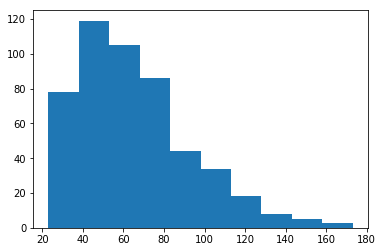

In [11]:
fig, ax = plt.subplots()
ax.hist(aopts1)

# M0 = 0.01 Mearth, aopt = 12

In [12]:
aopts01 = []
for i in range(500):
    aopts01.append((aopt(0.01*MEARTH)/AU))

(array([ 53., 107., 109.,  92.,  55.,  35.,  24.,  15.,   6.,   4.]),
 array([ 7.11212941, 11.7900146 , 16.4678998 , 21.145785  , 25.8236702 ,
        30.5015554 , 35.17944059, 39.85732579, 44.53521099, 49.21309619,
        53.89098138]),
 <a list of 10 Patch objects>)

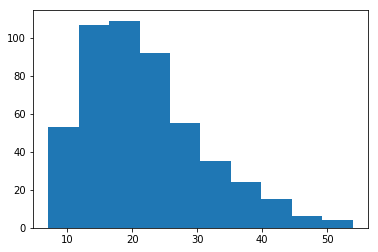

In [13]:
fig, ax = plt.subplots()
ax.hist(aopts01)

# M0 = 1.e-4 Mearth, aopt = 5

In [14]:
aopts0001 = []
for i in range(500):
    aopts0001.append((aopt(0.0001*MEARTH)/AU))

(array([ 62., 104.,  94., 102.,  55.,  38.,  22.,  11.,   8.,   4.]),
 array([ 2.59917019,  4.15663046,  5.71409073,  7.271551  ,  8.82901127,
        10.38647154, 11.94393181, 13.50139208, 15.05885235, 16.61631262,
        18.17377289]),
 <a list of 10 Patch objects>)

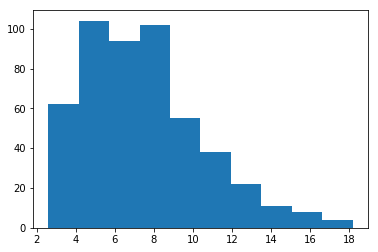

In [15]:
fig, ax = plt.subplots()
ax.hist(aopts0001)

# Sample

In [16]:
IWA = 0.2 # arcseconds
OWA = 1.2
MWA = (IWA + OWA)/2
lamb = 1.65 * MICRON

M0 = 1*MEARTH
aopt = 50 # AU
dopt = aopt/MWA * PC
print('Optimal Distance = {0:.0f} pc'.format(dopt/PC))

Optimal Distance = 71 pc


In [21]:
def sample(M0, dopt, lamb):
    star = star_sampler()
    star.d = distance_sampler(mean=dopt, std=dopt/2.)
    age = age_sampler()
    
    planet = draw_planet(star, age=age)
    if planet is None:
        return sample(M0, dopt, lamb) # do it again
    
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.5 # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    swarm = swarms.CollSwarm(star, planet, M0, Dt, Dmax, Q=Q, eta=eta, Nstr=Nstr, 
                            rho=rho, fQ=fQ, correction=True, Dmin_min=lamb, age=age)
    
    CRscatSwarm = swarm.computeCRscat(g)
    CRscatPlanet = planet.computeCRscat(g)
    CRthermalPlanet = planet.computeCRthermal(lamb)
    if np.isnan(CRthermalPlanet):
        CRthermalPlanet = 0
    return CRscatSwarm, CRscatPlanet+CRthermalPlanet, planet.a/AU, star.d/PC, planet.M, star.Imag

In [22]:
%%time
seed(0)
M0 = 1*MEARTH
Nsamples = 300
CRscatSwarm1, CRPlanet1, a, d, Mplt, Imag = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm1[i], CRPlanet1[i], a[i], d[i], Mplt[i], Imag[i] = sample(M0, dopt, lamb)

Wall time: 31.3 s


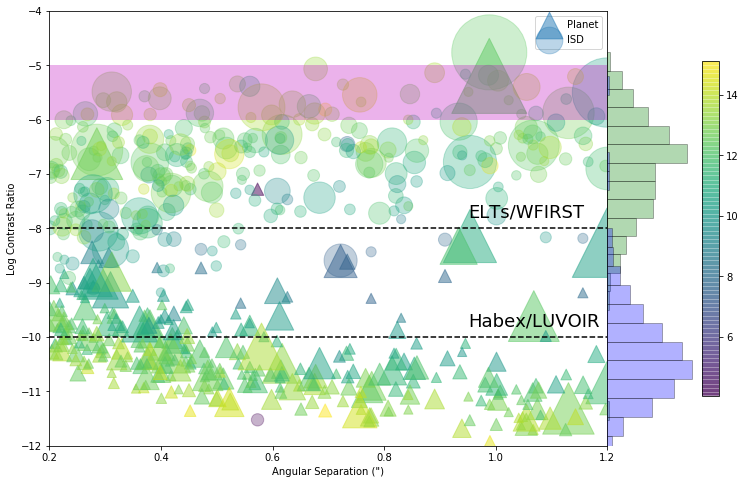

In [24]:
#plt.style.use('paper')
mask = (a/d > IWA) & (a/d < OWA)
cm = plt.cm.get_cmap('RdYlBu')

contrast = np.ones(1000)*1.e-5
contrastsep = np.linspace(0, 1.2, 1000)

sep = a[mask]/d[mask]
logCRscatSwarm1 = np.log10(CRscatSwarm1[mask])
logCRPlanet1 = np.log10(CRPlanet1[mask])
Imag1 = Imag[mask]
Mcut = 4*Mplt[mask]/MEARTH

fig, axarr = plt.subplots(figsize=(12,8), ncols=2, gridspec_kw = {'width_ratios':[5, 1]}, sharey=True)
sc = axarr[0].scatter(sep, logCRPlanet1, c=Imag1, s=Mcut, alpha=0.5, marker='^', label="Planet")
axarr[0].scatter(sep, logCRscatSwarm1, c=Imag1, s=Mcut, alpha=0.3, label="ISD")
#axarr[0].plot(contrastsep, np.log10(contrast), 'b-')
axarr[0].axhline(-8, color='k', linestyle='--')
axarr[0].axhline(-10, color='k', linestyle='--')
axarr[0].fill_between(np.linspace(0.2, 1.2, 10), -6, -5, facecolor='m', alpha=0.3)

axarr[0].set_xlim([0.2, 1.2])
axarr[0].set_ylim([-12, -4])
axarr[0].set_xlabel('Angular Separation (")')
axarr[0].set_ylabel('Log Contrast Ratio')
axarr[0].text(.95, -7.8, "ELTs/WFIRST", color='k', fontsize=18)
axarr[0].text(.95, -9.8, "Habex/LUVOIR", color='k', fontsize=18)
axarr[0].legend(markerscale=0.5)

plt.colorbar(sc)
plt.subplots_adjust(wspace=0)
axarr[1].set_axis_off()

nbins = 20
vals, bins, patches = axarr[1].hist(logCRscatSwarm1, orientation='horizontal', bins=nbins, facecolor='g', ec='k', alpha=0.3)
vals, bins, patches = axarr[1].hist(logCRPlanet1, orientation='horizontal', bins=nbins, facecolor='b', ec='k', alpha=0.3)

In [25]:
%%time
seed(0)
M0 = 0.01*MEARTH
Nsamples = 300
CRscatSwarm01, CRPlanet01, a, d, Mplt, Imag = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm01[i], CRPlanet01[i], a[i], d[i], Mplt[i], Imag[i] = sample(M0, dopt, lamb)

Wall time: 33.1 s


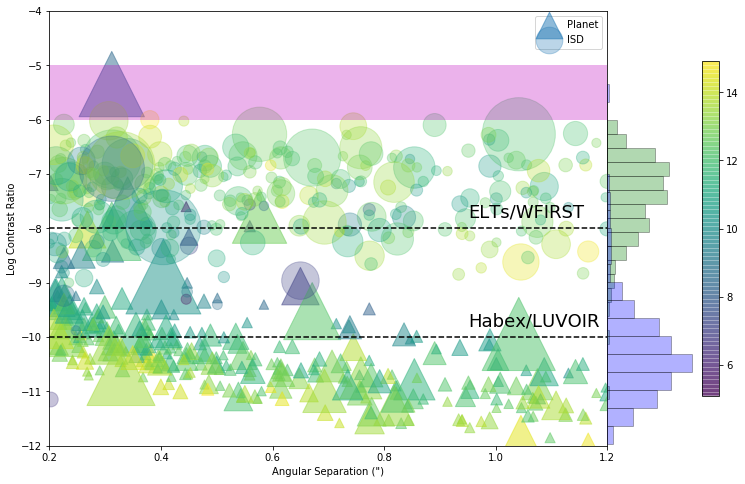

In [26]:
#plt.style.use('paper')
mask = (a/d > IWA) & (a/d < OWA)
cm = plt.cm.get_cmap('RdYlBu')

contrast = np.ones(1000)*1.e-5
contrastsep = np.linspace(0, 1.2, 1000)

sep = a[mask]/d[mask]
Imag1 = Imag[mask]
logCRscatSwarm01 = np.log10(CRscatSwarm01[mask])
logCRPlanet01 = np.log10(CRPlanet01[mask])
Mcut = 4*Mplt[mask]/MEARTH

fig, axarr = plt.subplots(figsize=(12,8), ncols=2, gridspec_kw = {'width_ratios':[5, 1]}, sharey=True)
sc = axarr[0].scatter(sep, logCRPlanet01, c=Imag1, marker='^', s=Mcut, alpha=0.5, label="Planet")
axarr[0].scatter(sep, logCRscatSwarm01, c=Imag1, s=Mcut, alpha=0.3, label="ISD")
#axarr[0].plot(contrastsep, np.log10(contrast), 'b-')
axarr[0].axhline(-8, color='k', linestyle='--')
axarr[0].axhline(-10, color='k', linestyle='--')
axarr[0].fill_between(np.linspace(0.2, 1.2, 10), -6, -5, facecolor='m', alpha=0.3)

axarr[0].set_xlim([0.2, 1.2])
axarr[0].set_ylim([-12, -4])
axarr[0].set_xlabel('Angular Separation (")')
axarr[0].set_ylabel('Log Contrast Ratio')
axarr[0].text(.95, -7.8, "ELTs/WFIRST", color='k', fontsize=18)
axarr[0].text(.95, -9.8, "Habex/LUVOIR", color='k', fontsize=18)
axarr[0].legend(markerscale=0.5)

plt.colorbar(sc)
plt.subplots_adjust(wspace=0)
axarr[1].set_axis_off()

nbins = 20
vals, bins, patches = axarr[1].hist(logCRscatSwarm01, orientation='horizontal', bins=nbins, facecolor='g', ec='k', alpha=0.3)
vals, bins, patches = axarr[1].hist(logCRPlanet01, orientation='horizontal', bins=nbins, facecolor='b', ec='k', alpha=0.3)

In [27]:
%%time
seed(0)
M0 = 1.e-6*MEARTH
Nsamples = 300
CRscatSwarm0001, CRPlanet0001, a, d, Mplt, Imag = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm0001[i], CRPlanet0001[i], a[i], d[i], Mplt[i], Imag[i] = sample(M0, dopt, lamb)

Wall time: 32 s


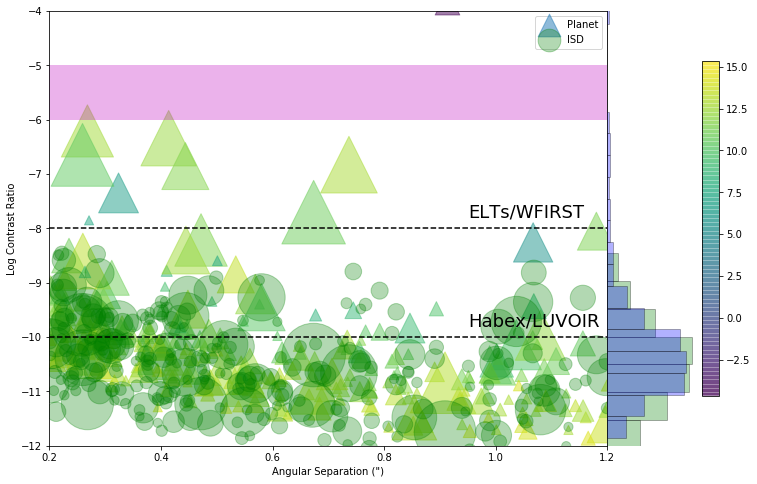

In [28]:
#plt.style.use('paper')
mask = (a/d > IWA) & (a/d < OWA)
cm = plt.cm.get_cmap('RdYlBu')

contrast = np.ones(1000)*1.e-5
contrastsep = np.linspace(0, 1.2, 1000)

sep = a[mask]/d[mask]
Imag1 = Imag[mask]
logCRscatSwarm0001 = np.log10(CRscatSwarm0001[mask])
logCRPlanet0001 = np.log10(CRPlanet0001[mask])
Mcut = 4*Mplt[mask]/MEARTH

fig, axarr = plt.subplots(figsize=(12,8), ncols=2, gridspec_kw = {'width_ratios':[5, 1]}, sharey=True)
sc = axarr[0].scatter(sep, logCRPlanet0001, c=Imag1, marker='^', s=Mcut, alpha=0.5, label="Planet")
axarr[0].scatter(sep, logCRscatSwarm0001, c='g', s=Mcut, alpha=0.3, label="ISD")
#axarr[0].plot(contrastsep, np.log10(contrast), 'b-')
axarr[0].axhline(-8, color='k', linestyle='--')
axarr[0].axhline(-10, color='k', linestyle='--')
axarr[0].fill_between(np.linspace(0.2, 1.2, 10), -6, -5, facecolor='m', alpha=0.3)

axarr[0].set_xlim([0.2, 1.2])
axarr[0].set_ylim([-12, -4])
axarr[0].set_xlabel('Angular Separation (")')
axarr[0].set_ylabel('Log Contrast Ratio')
axarr[0].text(.95, -7.8, "ELTs/WFIRST", color='k', fontsize=18)
axarr[0].text(.95, -9.8, "Habex/LUVOIR", color='k', fontsize=18)
axarr[0].legend(markerscale=0.5)

plt.colorbar(sc)
plt.subplots_adjust(wspace=0)
axarr[1].set_axis_off()

nbins = 20
vals, bins, patches = axarr[1].hist(logCRscatSwarm0001, orientation='horizontal', bins=nbins, facecolor='g', ec='k', alpha=0.3)
vals, bins, patches = axarr[1].hist(logCRPlanet0001, orientation='horizontal', bins=nbins, facecolor='b', ec='k', alpha=0.3)

Text(0,0.5,'Number of Planets')

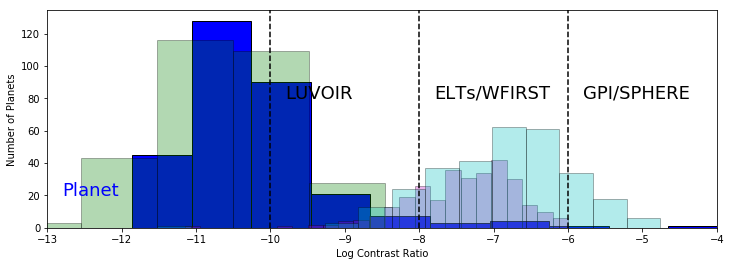

In [29]:
fig, ax = plt.subplots(figsize=(12,4))
hist, edges, patches = ax.hist(logCRPlanet0001, facecolor='b', ec='k')
hist, edges, patches = ax.hist(logCRscatSwarm0001, facecolor='g', ec='k', alpha=0.3)
hist, edges, patches = ax.hist(logCRscatSwarm01, bins=25, facecolor='m', ec='k', alpha=0.3)
hist, edges, patches = ax.hist(logCRscatSwarm1, bins=15, facecolor='c', ec='k', alpha=0.3)

ax.axvline(-6, color='k', linestyle='--')
ax.axvline(-8, color='k', linestyle='--')
ax.axvline(-10, color='k', linestyle='--')

ax.text(-12.8, 20, "Planet", color='b', fontsize=18)
ax.text(-9.8, 80, "LUVOIR", color='k', fontsize=18)
ax.text(-7.8, 80, "ELTs/WFIRST", color='k', fontsize=18)
ax.text(-5.8, 80, "GPI/SPHERE", color='k', fontsize=18)

#hist, edges, patches = ax.hist(logCRscat0001)
#ax.fill_betweenx([0, 300], -6, -4, facecolor='m', alpha=0.3)
#|ax.set_ylim([0, 250])
ax.set_xlim([-13, -4])
ax.set_xlabel('Log Contrast Ratio')
ax.set_ylabel('Number of Planets')